# Catastrophic Forgetting

## Introduction

The phenomenon of catastrophic forgetting, or catastrophic interference, was first observed by McCloskey and Cohen (1989). It is especially salient in online learning, where training data is fed sequentially to a machine learning model for training. In this notebook, we will explore the effects of catastrophic interference in the PES learning rule on MNIST data.

In [2]:
import nengo
import nengo_dl
import numpy as np
import tensorflow as tf
from PIL import Image
from nengo_extras.gui import image_display_function
from nengo_extras.vision import Gabor, Mask
from nengo_extras.data import one_hot_from_labels
from nengo.utils.filter_design import cont2discrete
from nengo_gui.ipython import IPythonViz


## MNIST Digit Recognition

We will experiment on catastrophic interference with MNIST.

In [3]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
n_train, height, width = X_train.shape
n_test = len(y_test)
n_classes = len(np.unique(y_train))

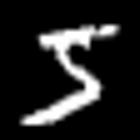

Label: 5
Max Pixel Val: 255
Min Pixel Val: 0


In [4]:
Image.fromarray(X_train[0]) \
    .resize((height * 5, width * 5)) \
    .show()

print(f"Label: {y_train[0]}")
print(f"Max Pixel Val: {np.max(X_train[0])}")
print(f"Min Pixel Val: {np.min(X_train[0])}")

In [5]:
# Batch preprocess the data into unit vector.
def preprocess(X):
    X = X.reshape(len(X), -1)
    X = X - X.mean(axis=1, keepdims=True)
    return X / np.linalg.norm(X, axis=1, keepdims=True)

In [6]:
# Preprocessing and One hot encode
X_train = preprocess(X_train)
y_train = one_hot_from_labels(y_train)
X_test = preprocess(X_test)
y_test = one_hot_from_labels(y_test)

## Neural Network

We build a 2 ensemble neural network with Nengo, and set the learning with PES learning rule.

In [7]:
# Some network configuration hyperparameters
input_display_time = 1
n_neurons = 5000

Neural networks in Nengo are fixed-encoding networks, whereby the encoders are fixed to a certain randomly generated value. Previous research has shown that Gabor filters best extracts the features of an image. Unlike in deep learning, where these Gabor filters are derived from backpropagation, we can only generate these Gabor filters randomly because backpropagation cannot be used in fixed-encoding SNN.

In [8]:
# Generate the encoders for the neural ensemble
gabor_size = (11, 11)
# Set the rng state (using a fixed seed that works)
rng = np.random.RandomState(9)
encoders = Gabor().generate(n_neurons, gabor_size, rng=rng)
encoders = Mask((height, width)).populate(encoders, rng=rng, flatten=True)

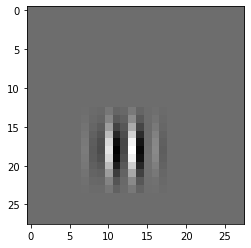

In [9]:
from matplotlib import pyplot as plt
plt.imshow(encoders[1].reshape(28,28), cmap="gray")

Below is the nengo model rendered as an interactive demo in Nengo GUI. You can see the effects of catastrophic forgetting when you inhibit the learning by moving the slider of inhibitor to 1 (Wait for 30s for the simulation to run and learn)

In [10]:
with nengo.Network(seed=3) as model:

    input_node = nengo.Node(
        nengo.processes.PresentInput(X_train, input_display_time),
        label="Input"
    )

    # Pre-synaptic ensemble
    pre_ens = nengo.Ensemble(
        n_neurons=n_neurons,
        dimensions=height * width,
        radius=1
    )
    
    nengo.Connection(input_node, pre_ens)
    
    post_ens = nengo.Ensemble(
        n_neurons=30*n_classes,
        dimensions=n_classes,
        radius=5
    )
    
    # Connection with synapse weight to be learned by PES
    # Weights are randomly initialized
    conn = nengo.Connection(
        pre_ens, post_ens,
        learning_rule_type=nengo.PES(),
        transform=np.random.rand(n_classes, width*height)
    )
    
    # Error signal representation
    error = nengo.Ensemble(
        n_neurons=30 * n_classes,
        dimensions=n_classes,
        radius=5
    )
    
    gt_node = nengo.Node(
        nengo.processes.PresentInput(y_train, input_display_time),
        label="Ground Truth"
    )
    nengo.Connection(post_ens, error)
    nengo.Connection(gt_node, error, transform=-1)
    nengo.Connection(error, conn.learning_rule)
    
    # Input image display (for nengo_gui)
    image_shape = (1, 28, 28)
    display_func = image_display_function(image_shape, offset=1, scale=128)
    display_node = nengo.Node(display_func, size_in=input_node.size_out)
    nengo.Connection(input_node, display_node, synapse=None)
    
    # Error inhibition control
    inhibitor = nengo.Node([0])
    nengo.Connection(
        inhibitor, error.neurons, 
        transform=-100*np.ones((error.n_neurons, 1))
    )
    

# Network visualization
IPythonViz(model)

You should see that once inhibitor is turned on, the neural network stops learning and just predicts everything as the predicted label of the last seen sample. This means that the last seen sample before inhibition has turned on has caused catastrophic forgetting in the synapse weights between pre-synaptic and post-synaptic neuron ensemble. This needs to be mitigated.

## In Offline Learning

Of course, the phenomenon of catastrophic forgetting is also visible in offline learning. In the next experiment, we use a LeNet5 built with PyTorch to simulate this behavior.

In [18]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import transforms
from tqdm.notebook import tqdm

In [12]:
class LeNet(nn.Module):
    
    def __init__(self):
        super(LeNet, self).__init__()
        self.convnet = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5),
            nn.ReLU(inplace=True),
        )
        
        self.fc1 = nn.Linear(in_features=120, out_features=84)
        self.fc2 = nn.Linear(in_features=84, out_features=10)
        
    def forward(self, img):
        X = self.convnet(img)
        X = torch.flatten(X, start_dim=1)
        X = self.fc1(X)
        X = nn.functional.relu(X)
        X = self.fc2(X)
        return X

The neural network will still train on a one hot vector of 10 classes (0 - 9), but we are going to not let it see the number 9 ever during initial training. Thus in PyTorch, we will have to create our custom dataset from MNIST with the filter.

In [13]:
class IncompleteMNIST(Dataset):
    """ Class for incomplete MNIST """
    
    def __init__(self, holdout=True, exclude=9, train=True):
        """
        :param holdout: mode of instantiation of this dataset. If holdout=True,
            data of a certain label will be excluded from training. If holdout=False,
            only the excluded data will be trained.
        :param exclude: label of data to be excluded during holdout.
        :param train: Set training or testing mode.
        """
        if train:
            (imgs, labels), _ = tf.keras.datasets.mnist.load_data()
        else:
            _, (imgs, labels) = tf.keras.datasets.mnist.load_data()
            
        if holdout:
            self.imgs = imgs[labels != exclude]
            self.labels = labels[labels != exclude]
        else:
            self.imgs = imgs[labels == exclude]
            self.labels = labels[labels == exclude]
        
        # Padding because LeNet5 requires 32 x 32 x 1 images as inputs
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Pad(2)
        ])
            
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.transform(self.imgs[idx]), self.labels[idx]
            

In [14]:
trainset = IncompleteMNIST()
valset = IncompleteMNIST(train=False)
img, label = trainset[0]
print(f"Image size: {img.shape}")
print(f"label: {label}")
print(f"{len(trainset)} training data")
print(f"{len(valset)} validation data")

Image size: torch.Size([1, 32, 32])
label: 5
54051 training data
8991 validation data


Now, we shall perform training on the data that was held out.

In [15]:
# Setup training
model = LeNet()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

train_loader = torch.utils.data.DataLoader(
                    trainset, 
                    batch_size=4, 
                    shuffle=True,
                    num_workers=2
                )

val_loader = torch.utils.data.DataLoader(
                    valset, 
                    batch_size=4, 
                    shuffle=True,
                    num_workers=2
                )

In [17]:
def train(model):
    running_loss = 0.0
    last_loss = 0.0
    
    for i, data in enumerate(train_loader):
        imgs, labels = data
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(imgs)
        
        # Compute loss and backpropagate error gradients
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Gradient descent
        optimizer.step()
        
        # Gather running loss
        running_loss += loss.item()
        
        # Calculate avg loss across 1000 batches
        if i % 1000 == 999:
            last_loss = running_loss / 1000
            running_loss = 0.0
        
    return last_loss

In [19]:
# Epoch Training
num_epochs = 40

best_vloss = 1_000_000

for epoch in tqdm(range(num_epochs)):
    model.train(True)
    
    # Inner training loop
    avg_loss = train(model)
    
    # Turn off training for reporting
    model.train(False)
    
    running_vloss = 0.0
    for i, vdata in enumerate(val_loader):
        v_inputs, v_labels = vdata
        v_outputs = model(v_inputs)
        v_loss = criterion(v_outputs, v_labels)
        running_vloss += v_loss
        
    avg_vloss = running_vloss / (i + 1)
    tqdm.write(f"Train loss: {avg_loss}, Validation loss: {avg_vloss}")

  0%|          | 0/40 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Discussion

We have seen the effects of catastrophic forgetting on neural networks in both a sequential learning scenario and a offline batch learning scenario. After seeing that such a phenomenon happens, we can move to try and resolve this problem.

## Legendre Memory Units

LMUs is a type of recurrent neural network cell that aims to implement a perfect delay. It was first published by Volker, Kajic and Eliasmith (NeurIPs 2019) and has been shown to beat LSTMs on psMNIST dataset.

<img src="https://i.imgur.com/IJGUVg6.png" alt="drawing" width="500"/>

In [17]:
class LMUCell(nengo.Network):
    """ Legendre Memory Unit """
    
    def __init__(self, units, order, theta, input_d, **kwargs):
        """ Constructor for LMU
        
        :param units:
        :param order: The order of Lengendre Polynomials to use.
        :param theta: Delay amount defining the sliding window from [t-theta, t]. 
                Can also be interpreted as length of time window.
        :param input_d: Dimension of input signal X
        """
        super().__init__(**kwargs)
        
        # Compute the analytically derived weight matrices used in LMU
        # These are determined statistically based on the theta/order parameters.
        Q = np.arange(order, dtype=np.float64)
        R = (2 * Q + 1)[:, None] / theta
        j, i = np.mesgrid(Q, Q)
        
        A = np.where(i < j, -1, (-1, 0) ** (i - j + 1) * R)
        B = (-1.0) ** Q[:, None] * R
        C = np.ones((1, order))
        D = np.zeros((1,))
        
        A, B, _, _, _ = cont2discrete((A, B, C, D), dt=1.0, method="zoh")
        
        with self:
            nengo_dl.configure_settings(trainable=None)
            
            # Create objects corresponding to x/u/m/h variables of LMU cell
            # There is a bit of notational change compared to X and U in NEF
            # self.u is the input as seen by the dynamical system, self.m is the state from previous time,
            # self.x is our actual data input.
            self.x = nengo.Node(size_in=input_d)
            self.u = nengo.Node(size_in=1)
            self.m = nengo.Node(size_in=order)
            self.h = nengo_dl.TensorNode(tf.nn.tanh, shape_in(units,), pass_time=False)
            
            # Compute u_t in the LMU cell. We have removed e_h and e_m as they are not needed in
            # the psMNIST task. e_x is trainable, but initialized to np.ones instead of nengo_dl.dists.Glorot()
            nengo.Connection(
                self.x, self.u, transform=np.ones((1, input_d), synapse=None)
            )
            
            # Compute m_t
            # In this implementation we'll make A and B non-trainable, but they
            # can also be optimized in the same way as other parameters. Note
            # that setting synapse=0 (versus synapse=None) adds a one-timestep
            # delay, so we can think of any connections with synapse=0 as representing
            # value_{t-1}
            conn_A = nengo.Connection(self.m, self.m, transform=A, synapse=0)
            self.config[conn_A].trainable = False
            conn_B = nengo.Connection(self.u, self.m, transform=B, synapse=None)
            self.config[conn_B].trainable = False
            
            # Compute h_t
            nengo.Connection(
                # This is the W_x connection
                self.x, self.h, transform=nengo_dl.dists.Glorot(), synapse=None
            )
            nengo.Connection(
                # This is the W_h connection
                self.h, self.h, transform=nengo_dl.dists.Glorot(), synapse=0
            )
            nengo.Connection(
                # This is the W_m connection
                self.m, self.h, transform=nengo_dl.dists.Glorot(), synapse=None
            )
            

In the above code, conn_A and conn_B 